# MNIST without Acquisition function

based on [this github](https://github.com/jiuntian/pytorch-mnist-example/blob/master/pytorch-mnist.ipynb)

In [30]:
import torch
import torchvision

import warnings
warnings.filterwarnings("ignore")


In [31]:
batch_size_train = 512
batch_size_test = 1024 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)


## Looking at the data

Label: tensor(6)


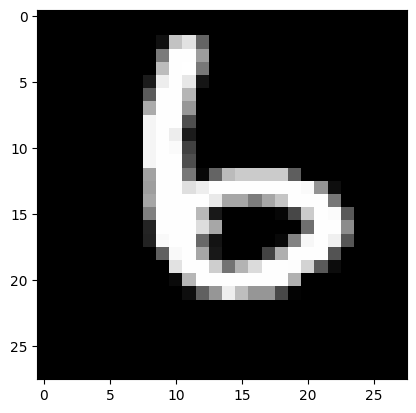

In [32]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0][0]
# show the data
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))

## initializing the neural network

In [33]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [35]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5
model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [36]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
##define test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return correct / len(test_loader.dataset)

In [37]:
num_epoch = 2
for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 1.8764, Accuracy: 4396/10000 (44%)



  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.8103, Accuracy: 7530/10000 (75%)



# MNIST with acquisition function

In this part we will train the CNN by using multiple different acquisition functions to see which acquisition function works best.

-----------------------------

We will compare the different acquisition function by plotting the highest achieved accuracy compared to the number of datapoints requested by the acquisition function.

In [59]:
import numpy as np
import random
import pickle
from collections import Counter

# entropy

In [60]:
def entropy(model, dataset, batch_size=1028):
    model.eval()
    entropies = []

    # Create a DataLoader for the dataset with the specified batch size
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for inputs, _ in data_loader:
        with torch.no_grad():
            outputs = model(inputs.to(device))
            # Calculate softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)
            # Calculate entropy for each sample in the batch
            entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
            # Append the entropies for the batch to the list
            entropies.extend(entropy.cpu().numpy())

    return np.array(entropies)

In [61]:
def get_labels_from_pool_entropy(model, pool, current_labeled_dataset, amount_of_labels):
    entropies = entropy(model, train_dataset)

    # Convert entropies to a numpy array for sorting
    entropies = np.array(entropies)

    # Sort the dataset based on entropy values (in ascending order)
    sorted_indices = np.argsort(entropies)

    # Get the indices of the "amount_of_labels" data points with the highest entropy values
    top_entropy_indices = sorted_indices[-amount_of_labels:]

    # Create a new dataset with the "amount_of_labels" data points with the highest entropy
    high_entropy_data = [train_dataset[i] for i in top_entropy_indices]

    # Remove the "amount_of_labels" high-entropy data points from the original dataset
    for i in sorted(top_entropy_indices, reverse=True):
        pool.data = torch.cat((pool.data[:i], pool.data[i+1:]))
        pool.targets = torch.cat((pool.targets[:i], pool.targets[i+1:]))

    current_labeled_dataset.extend(high_entropy_data)

    return


In [62]:
def active_learning_loop_entropy(model, device, full_labeled_dataset, optimizer, target_accuracy=0.90, growth_rate=1000, N=5, batch_size_train=512):
    active_learning_dataset = []  # Initialize the active learning dataset
    current_epoch = 0
    accuracies = dict()
    label_counts_per_epoch = dict()

    while True:
        # Train on the current active learning dataset for N epochs
        print(f"getting {growth_rate} number of datapoints 'labeled'")
        get_labels_from_pool_entropy(model, full_labeled_dataset, active_learning_dataset, growth_rate)
        label_counts = Counter([label for _, label in active_learning_dataset])
        label_counts_per_epoch[current_epoch] = dict()
        for label, counts in label_counts.items():
            label_counts_per_epoch[current_epoch][label] = counts

        print(f"Training on current dataset for {N} epochs on {len(active_learning_dataset)} datapoints")
        active_learning_loader = torch.utils.data.DataLoader(active_learning_dataset, batch_size=batch_size_train, shuffle=True)
        for epoch in range(current_epoch, current_epoch + N):
            train(model, device, active_learning_loader, optimizer, epoch)  # Use active_learning_loader for training
            accuracy = test(model, device, test_loader)
            if len(active_learning_dataset) not in accuracies:
                accuracies[len(active_learning_dataset)] = []

            accuracies[len(active_learning_dataset)].append(accuracy)
            
            current_epoch += 1

        if accuracy >= target_accuracy:
            print(f"after {current_epoch} epochs and {len(active_learning_dataset)} number of datapoints an accuracy of {target_accuracy} is reached")
            break

    return accuracies, label_counts_per_epoch
        

       

In [63]:
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)

model1 = CNN().to(device)
optimizer = optim.SGD(model1.parameters(), lr=learning_rate,
                      momentum=momentum)

nrpooledvalues_acc_entropy, label_counts_per_epoch_entropy = active_learning_loop_entropy(model1, device, train_dataset, optimizer)

filename = 'nrpooledvalues_acc_entropy.pkl'
with open(filename, 'wb') as file:
    pickle.dump(nrpooledvalues_acc_entropy, file)

filename = 'label_counts_per_epoch_entropy.pkl'
with open(filename, 'wb') as file:
    pickle.dump(label_counts_per_epoch_entropy, file)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 1000 datapoints


  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 2.3146, Accuracy: 1034/10000 (10%)



  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 2.3117, Accuracy: 1096/10000 (11%)



  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 2.3079, Accuracy: 1072/10000 (11%)



  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 2.3065, Accuracy: 1091/10000 (11%)



  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 2.3045, Accuracy: 1090/10000 (11%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 2000 datapoints


  0%|          | 0/4 [00:00<?, ?it/s]


Test set: Average loss: 2.3010, Accuracy: 1108/10000 (11%)



  0%|          | 0/4 [00:00<?, ?it/s]


Test set: Average loss: 2.2951, Accuracy: 1125/10000 (11%)



  0%|          | 0/4 [00:00<?, ?it/s]


Test set: Average loss: 2.2913, Accuracy: 1203/10000 (12%)



  0%|          | 0/4 [00:00<?, ?it/s]


Test set: Average loss: 2.2880, Accuracy: 1296/10000 (13%)



  0%|          | 0/4 [00:00<?, ?it/s]


Test set: Average loss: 2.2842, Accuracy: 1329/10000 (13%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 3000 datapoints


  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.2735, Accuracy: 1538/10000 (15%)



  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.2615, Accuracy: 1775/10000 (18%)



  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.2488, Accuracy: 1929/10000 (19%)



  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.2329, Accuracy: 2117/10000 (21%)



  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.2179, Accuracy: 2232/10000 (22%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 4000 datapoints


  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 2.1854, Accuracy: 2654/10000 (27%)



  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 2.1462, Accuracy: 3187/10000 (32%)



  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 2.1016, Accuracy: 3559/10000 (36%)



  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 2.0434, Accuracy: 3834/10000 (38%)



  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 1.9737, Accuracy: 4073/10000 (41%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 5000 datapoints


  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 1.8718, Accuracy: 4379/10000 (44%)



  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 1.7467, Accuracy: 4733/10000 (47%)



  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 1.6295, Accuracy: 5154/10000 (52%)



  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 1.4994, Accuracy: 5536/10000 (55%)



  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 1.3754, Accuracy: 5809/10000 (58%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 6000 datapoints


  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 1.2523, Accuracy: 6096/10000 (61%)



  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 1.1301, Accuracy: 6475/10000 (65%)



  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 1.0220, Accuracy: 6825/10000 (68%)



  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.9463, Accuracy: 7002/10000 (70%)



  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 0.8785, Accuracy: 7259/10000 (73%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 7000 datapoints


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.8239, Accuracy: 7452/10000 (75%)



  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7508, Accuracy: 7665/10000 (77%)



  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.7142, Accuracy: 7751/10000 (78%)



  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.6797, Accuracy: 7931/10000 (79%)



  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 0.6504, Accuracy: 7951/10000 (80%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 8000 datapoints


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.6229, Accuracy: 8093/10000 (81%)



  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5836, Accuracy: 8200/10000 (82%)



  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5624, Accuracy: 8317/10000 (83%)



  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5556, Accuracy: 8298/10000 (83%)



  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 0.5259, Accuracy: 8338/10000 (83%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 9000 datapoints


  0%|          | 0/18 [00:00<?, ?it/s]


Test set: Average loss: 0.5141, Accuracy: 8422/10000 (84%)



  0%|          | 0/18 [00:00<?, ?it/s]


Test set: Average loss: 0.4856, Accuracy: 8507/10000 (85%)



  0%|          | 0/18 [00:00<?, ?it/s]


Test set: Average loss: 0.4758, Accuracy: 8530/10000 (85%)



  0%|          | 0/18 [00:00<?, ?it/s]


Test set: Average loss: 0.4667, Accuracy: 8547/10000 (85%)



  0%|          | 0/18 [00:00<?, ?it/s]


Test set: Average loss: 0.4489, Accuracy: 8640/10000 (86%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 10000 datapoints


  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.4384, Accuracy: 8701/10000 (87%)



  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.4252, Accuracy: 8693/10000 (87%)



  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.4251, Accuracy: 8711/10000 (87%)



  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.4021, Accuracy: 8788/10000 (88%)



  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.3822, Accuracy: 8856/10000 (89%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 11000 datapoints


  0%|          | 0/22 [00:00<?, ?it/s]


Test set: Average loss: 0.3865, Accuracy: 8832/10000 (88%)



  0%|          | 0/22 [00:00<?, ?it/s]


Test set: Average loss: 0.3772, Accuracy: 8867/10000 (89%)



  0%|          | 0/22 [00:00<?, ?it/s]


Test set: Average loss: 0.3578, Accuracy: 8916/10000 (89%)



  0%|          | 0/22 [00:00<?, ?it/s]


Test set: Average loss: 0.3553, Accuracy: 8962/10000 (90%)



  0%|          | 0/22 [00:00<?, ?it/s]


Test set: Average loss: 0.3387, Accuracy: 8951/10000 (90%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 12000 datapoints


  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average loss: 0.3433, Accuracy: 8985/10000 (90%)



  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average loss: 0.3331, Accuracy: 9007/10000 (90%)



  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average loss: 0.3283, Accuracy: 9065/10000 (91%)



  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average loss: 0.3120, Accuracy: 9059/10000 (91%)



  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average loss: 0.3111, Accuracy: 9091/10000 (91%)

after 60 epochs and 12000 number of datapoints an accuracy of 0.9 is reached


# dropout difference

In [26]:
def dropout_diff(model, dataset, batch_size=1028):
    model.eval()
    criterion = nn.MSELoss(reduction='none')
    differences = []

    # Create a DataLoader for the dataset with the specified batch size
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for inputs, _ in data_loader:
        with torch.no_grad():
            model.eval()
            for m in model.modules():
                if m.__class__.__name__.startswith('Dropout'):
                    m.train()
            outputs_wdropout = model(inputs.to(device))

            model.eval()
            for m in model.modules():
                if m.__class__.__name__.startswith('Dropout'):
                    m.train()
            outputs_normal = model(inputs.to(device))

            loss = criterion(outputs_wdropout, outputs_normal)

            loss_per_item = torch.mean(loss, dim=1, keepdim=True)

            # Append the entropies for the batch to the list
            differences.extend(loss_per_item.cpu().numpy())


    return np.array(differences)

In [54]:
def get_labels_from_dropout_diff(model, pool, current_labeled_dataset, amount_of_labels):
    dropout_diffs = dropout_diff(model, train_dataset)

    # Convert entropies to a numpy array for sorting
    dropout_diffs = np.array(dropout_diffs)
    dropout_diffs = np.concatenate(dropout_diffs, axis=0)

    # Sort the dataset based on entropy values (in ascending order)
    sorted_indices = np.argsort(dropout_diffs)

    # Get the indices of the "amount_of_labels" data points with the highest entropy values
    top_entropy_indices = sorted_indices[-amount_of_labels:]

    # Create a new dataset with the "amount_of_labels" data points with the highest entropy
    high_diff_data = [train_dataset[i] for i in top_entropy_indices]

    # Remove the "amount_of_labels" high-entropy data points from the original dataset
    for i in sorted(top_entropy_indices, reverse=True):
        pool.data = torch.cat((pool.data[:i], pool.data[i+1:]))
        pool.targets = torch.cat((pool.targets[:i], pool.targets[i+1:]))

    current_labeled_dataset.extend(high_diff_data)

    return

In [57]:
def active_learning_loop_dropout_diff(model, device, full_labeled_dataset, optimizer, target_accuracy=0.90, growth_rate=1000, N=5, batch_size_train=512):
    active_learning_dataset = []  # Initialize the active learning dataset
    current_epoch = 0
    accuracies = dict()
    label_counts_per_epoch = dict()


    while True:
        # Train on the current active learning dataset for N epochs
        print(f"getting {growth_rate} number of datapoints 'labeled'")
        get_labels_from_dropout_diff(model, full_labeled_dataset, active_learning_dataset, growth_rate)
        label_counts = Counter([label for _, label in active_learning_dataset])
        label_counts_per_epoch[current_epoch] = dict()
        for label, counts in label_counts.items():
            label_counts_per_epoch[current_epoch][label] = counts

        print(f"Training on current dataset for {N} epochs on {len(active_learning_dataset)} datapoints")
        active_learning_loader = torch.utils.data.DataLoader(active_learning_dataset, batch_size=batch_size_train, shuffle=True)
        for epoch in range(current_epoch, current_epoch + N):
            train(model, device, active_learning_loader, optimizer, epoch)  # Use active_learning_loader for training
            accuracy = test(model, device, test_loader)
            if len(active_learning_dataset) not in accuracies:
                accuracies[len(active_learning_dataset)] = []

            accuracies[len(active_learning_dataset)].append(accuracy)

            current_epoch += 1

        if accuracy >= target_accuracy:
            print(f"after {current_epoch} epochs and {len(active_learning_dataset)} number of datapoints an accuracy of {target_accuracy} is reached")
            break

    return accuracies, label_counts_per_epoch
        

       

In [58]:
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)

model2 = CNN().to(device)
optimizer = optim.SGD(model2.parameters(), lr=learning_rate,
                      momentum=momentum)

nrpooledvalues_acc_dropout_diff, label_counts_per_epoch_dropout_diff = active_learning_loop_dropout_diff(model2, device, train_dataset, optimizer)

filename = 'nrpooledvalues_acc_dropout_diff.pkl'
with open(filename, 'wb') as file:
    pickle.dump(nrpooledvalues_acc_dropout_diff, file)

filename = 'label_counts_per_epoch_dropout_diff.pkl'
with open(filename, 'wb') as file:
    pickle.dump(label_counts_per_epoch_dropout_diff, file)



getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 1000 datapoints


  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 2.3066, Accuracy: 1210/10000 (12%)



  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 2.3003, Accuracy: 1185/10000 (12%)



  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 2.2955, Accuracy: 1226/10000 (12%)



  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 2.2897, Accuracy: 1230/10000 (12%)



  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 2.2910, Accuracy: 1236/10000 (12%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 2000 datapoints


  0%|          | 0/4 [00:00<?, ?it/s]


Test set: Average loss: 2.2897, Accuracy: 1259/10000 (13%)



  0%|          | 0/4 [00:00<?, ?it/s]


Test set: Average loss: 2.2949, Accuracy: 1301/10000 (13%)



  0%|          | 0/4 [00:00<?, ?it/s]


Test set: Average loss: 2.2968, Accuracy: 1393/10000 (14%)



  0%|          | 0/4 [00:00<?, ?it/s]


Test set: Average loss: 2.2967, Accuracy: 1462/10000 (15%)



  0%|          | 0/4 [00:00<?, ?it/s]


Test set: Average loss: 2.2931, Accuracy: 1482/10000 (15%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 3000 datapoints


  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.2849, Accuracy: 1552/10000 (16%)



  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.2748, Accuracy: 1590/10000 (16%)



  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.2497, Accuracy: 1784/10000 (18%)



  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.2179, Accuracy: 1994/10000 (20%)



  0%|          | 0/6 [00:00<?, ?it/s]


Test set: Average loss: 2.1974, Accuracy: 2153/10000 (22%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 4000 datapoints


  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 2.1365, Accuracy: 2419/10000 (24%)



  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 2.0658, Accuracy: 2848/10000 (28%)



  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 2.0063, Accuracy: 3116/10000 (31%)



  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 1.9218, Accuracy: 3588/10000 (36%)



  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 1.8431, Accuracy: 3911/10000 (39%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 5000 datapoints


  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 1.7737, Accuracy: 4219/10000 (42%)



  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 1.6971, Accuracy: 4486/10000 (45%)



  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 1.6333, Accuracy: 4794/10000 (48%)



  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 1.5627, Accuracy: 5021/10000 (50%)



  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 1.5131, Accuracy: 5137/10000 (51%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 6000 datapoints


  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 1.4568, Accuracy: 5330/10000 (53%)



  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 1.4147, Accuracy: 5387/10000 (54%)



  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 1.3885, Accuracy: 5436/10000 (54%)



  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 1.3273, Accuracy: 5625/10000 (56%)



  0%|          | 0/12 [00:00<?, ?it/s]


Test set: Average loss: 1.2944, Accuracy: 5829/10000 (58%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 7000 datapoints


  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 1.2580, Accuracy: 5950/10000 (60%)



  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 1.2405, Accuracy: 5938/10000 (59%)



  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 1.1906, Accuracy: 6070/10000 (61%)



  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 1.1687, Accuracy: 6168/10000 (62%)



  0%|          | 0/14 [00:00<?, ?it/s]


Test set: Average loss: 1.1372, Accuracy: 6247/10000 (62%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 8000 datapoints


  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 1.1194, Accuracy: 6296/10000 (63%)



  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 1.0779, Accuracy: 6443/10000 (64%)



  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 1.0572, Accuracy: 6441/10000 (64%)



  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 1.0414, Accuracy: 6506/10000 (65%)



  0%|          | 0/16 [00:00<?, ?it/s]


Test set: Average loss: 1.0209, Accuracy: 6607/10000 (66%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 9000 datapoints


  0%|          | 0/18 [00:00<?, ?it/s]


Test set: Average loss: 0.9888, Accuracy: 6717/10000 (67%)



  0%|          | 0/18 [00:00<?, ?it/s]


Test set: Average loss: 0.9705, Accuracy: 6749/10000 (67%)



  0%|          | 0/18 [00:00<?, ?it/s]


Test set: Average loss: 0.9382, Accuracy: 6832/10000 (68%)



  0%|          | 0/18 [00:00<?, ?it/s]


Test set: Average loss: 0.9231, Accuracy: 6820/10000 (68%)



  0%|          | 0/18 [00:00<?, ?it/s]


Test set: Average loss: 0.9120, Accuracy: 6939/10000 (69%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 10000 datapoints


  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.8812, Accuracy: 7015/10000 (70%)



  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.8800, Accuracy: 7009/10000 (70%)



  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.8445, Accuracy: 7191/10000 (72%)



  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.8565, Accuracy: 7122/10000 (71%)



  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 0.8491, Accuracy: 7126/10000 (71%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 11000 datapoints


  0%|          | 0/22 [00:00<?, ?it/s]


Test set: Average loss: 0.8180, Accuracy: 7223/10000 (72%)



  0%|          | 0/22 [00:00<?, ?it/s]


Test set: Average loss: 0.8141, Accuracy: 7255/10000 (73%)



  0%|          | 0/22 [00:00<?, ?it/s]


Test set: Average loss: 0.8088, Accuracy: 7229/10000 (72%)



  0%|          | 0/22 [00:00<?, ?it/s]


Test set: Average loss: 0.7931, Accuracy: 7338/10000 (73%)



  0%|          | 0/22 [00:00<?, ?it/s]


Test set: Average loss: 0.7784, Accuracy: 7365/10000 (74%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 12000 datapoints


  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average loss: 0.7664, Accuracy: 7423/10000 (74%)



  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average loss: 0.7388, Accuracy: 7575/10000 (76%)



  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average loss: 0.7351, Accuracy: 7530/10000 (75%)



  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average loss: 0.7311, Accuracy: 7544/10000 (75%)



  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average loss: 0.7312, Accuracy: 7589/10000 (76%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 13000 datapoints


  0%|          | 0/26 [00:00<?, ?it/s]


Test set: Average loss: 0.7125, Accuracy: 7633/10000 (76%)



  0%|          | 0/26 [00:00<?, ?it/s]


Test set: Average loss: 0.7044, Accuracy: 7676/10000 (77%)



  0%|          | 0/26 [00:00<?, ?it/s]


Test set: Average loss: 0.7057, Accuracy: 7634/10000 (76%)



  0%|          | 0/26 [00:00<?, ?it/s]


Test set: Average loss: 0.6848, Accuracy: 7734/10000 (77%)



  0%|          | 0/26 [00:00<?, ?it/s]


Test set: Average loss: 0.6801, Accuracy: 7706/10000 (77%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 14000 datapoints


  0%|          | 0/28 [00:00<?, ?it/s]


Test set: Average loss: 0.6750, Accuracy: 7769/10000 (78%)



  0%|          | 0/28 [00:00<?, ?it/s]


Test set: Average loss: 0.6683, Accuracy: 7821/10000 (78%)



  0%|          | 0/28 [00:00<?, ?it/s]


Test set: Average loss: 0.6621, Accuracy: 7801/10000 (78%)



  0%|          | 0/28 [00:00<?, ?it/s]


Test set: Average loss: 0.6545, Accuracy: 7817/10000 (78%)



  0%|          | 0/28 [00:00<?, ?it/s]


Test set: Average loss: 0.6436, Accuracy: 7852/10000 (79%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 15000 datapoints


  0%|          | 0/30 [00:00<?, ?it/s]


Test set: Average loss: 0.6391, Accuracy: 7866/10000 (79%)



  0%|          | 0/30 [00:00<?, ?it/s]


Test set: Average loss: 0.6244, Accuracy: 7943/10000 (79%)



  0%|          | 0/30 [00:00<?, ?it/s]


Test set: Average loss: 0.6150, Accuracy: 7996/10000 (80%)



  0%|          | 0/30 [00:00<?, ?it/s]


Test set: Average loss: 0.6125, Accuracy: 8039/10000 (80%)



  0%|          | 0/30 [00:00<?, ?it/s]


Test set: Average loss: 0.6108, Accuracy: 8053/10000 (81%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 16000 datapoints


  0%|          | 0/32 [00:00<?, ?it/s]


Test set: Average loss: 0.6094, Accuracy: 8002/10000 (80%)



  0%|          | 0/32 [00:00<?, ?it/s]


Test set: Average loss: 0.6096, Accuracy: 8001/10000 (80%)



  0%|          | 0/32 [00:00<?, ?it/s]


Test set: Average loss: 0.6019, Accuracy: 8025/10000 (80%)



  0%|          | 0/32 [00:00<?, ?it/s]


Test set: Average loss: 0.5950, Accuracy: 8080/10000 (81%)



  0%|          | 0/32 [00:00<?, ?it/s]


Test set: Average loss: 0.5964, Accuracy: 8050/10000 (80%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 17000 datapoints


  0%|          | 0/34 [00:00<?, ?it/s]


Test set: Average loss: 0.5985, Accuracy: 8061/10000 (81%)



  0%|          | 0/34 [00:00<?, ?it/s]


Test set: Average loss: 0.5895, Accuracy: 8057/10000 (81%)



  0%|          | 0/34 [00:00<?, ?it/s]


Test set: Average loss: 0.5885, Accuracy: 8024/10000 (80%)



  0%|          | 0/34 [00:00<?, ?it/s]


Test set: Average loss: 0.5744, Accuracy: 8108/10000 (81%)



  0%|          | 0/34 [00:00<?, ?it/s]


Test set: Average loss: 0.5668, Accuracy: 8124/10000 (81%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 18000 datapoints


  0%|          | 0/36 [00:00<?, ?it/s]


Test set: Average loss: 0.5601, Accuracy: 8212/10000 (82%)



  0%|          | 0/36 [00:00<?, ?it/s]


Test set: Average loss: 0.5481, Accuracy: 8163/10000 (82%)



  0%|          | 0/36 [00:00<?, ?it/s]


Test set: Average loss: 0.5592, Accuracy: 8144/10000 (81%)



  0%|          | 0/36 [00:00<?, ?it/s]


Test set: Average loss: 0.5545, Accuracy: 8188/10000 (82%)



  0%|          | 0/36 [00:00<?, ?it/s]


Test set: Average loss: 0.5661, Accuracy: 8132/10000 (81%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 19000 datapoints


  0%|          | 0/38 [00:00<?, ?it/s]


Test set: Average loss: 0.5446, Accuracy: 8199/10000 (82%)



  0%|          | 0/38 [00:00<?, ?it/s]


Test set: Average loss: 0.5480, Accuracy: 8192/10000 (82%)



  0%|          | 0/38 [00:00<?, ?it/s]


Test set: Average loss: 0.5480, Accuracy: 8171/10000 (82%)



  0%|          | 0/38 [00:00<?, ?it/s]


Test set: Average loss: 0.5167, Accuracy: 8309/10000 (83%)



  0%|          | 0/38 [00:00<?, ?it/s]


Test set: Average loss: 0.5272, Accuracy: 8310/10000 (83%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 20000 datapoints


  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.5196, Accuracy: 8307/10000 (83%)



  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.5193, Accuracy: 8302/10000 (83%)



  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.5201, Accuracy: 8317/10000 (83%)



  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.4951, Accuracy: 8355/10000 (84%)



  0%|          | 0/40 [00:00<?, ?it/s]


Test set: Average loss: 0.5031, Accuracy: 8350/10000 (84%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 21000 datapoints


  0%|          | 0/42 [00:00<?, ?it/s]


Test set: Average loss: 0.4970, Accuracy: 8385/10000 (84%)



  0%|          | 0/42 [00:00<?, ?it/s]


Test set: Average loss: 0.4872, Accuracy: 8459/10000 (85%)



  0%|          | 0/42 [00:00<?, ?it/s]


Test set: Average loss: 0.4874, Accuracy: 8424/10000 (84%)



  0%|          | 0/42 [00:00<?, ?it/s]


Test set: Average loss: 0.4897, Accuracy: 8433/10000 (84%)



  0%|          | 0/42 [00:00<?, ?it/s]


Test set: Average loss: 0.4744, Accuracy: 8475/10000 (85%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 22000 datapoints


  0%|          | 0/43 [00:00<?, ?it/s]


Test set: Average loss: 0.4712, Accuracy: 8430/10000 (84%)



  0%|          | 0/43 [00:00<?, ?it/s]


Test set: Average loss: 0.4782, Accuracy: 8419/10000 (84%)



  0%|          | 0/43 [00:00<?, ?it/s]


Test set: Average loss: 0.4781, Accuracy: 8457/10000 (85%)



  0%|          | 0/43 [00:00<?, ?it/s]


Test set: Average loss: 0.4770, Accuracy: 8470/10000 (85%)



  0%|          | 0/43 [00:00<?, ?it/s]


Test set: Average loss: 0.4632, Accuracy: 8518/10000 (85%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 23000 datapoints


  0%|          | 0/45 [00:00<?, ?it/s]


Test set: Average loss: 0.4528, Accuracy: 8568/10000 (86%)



  0%|          | 0/45 [00:00<?, ?it/s]


Test set: Average loss: 0.4607, Accuracy: 8538/10000 (85%)



  0%|          | 0/45 [00:00<?, ?it/s]


Test set: Average loss: 0.4502, Accuracy: 8555/10000 (86%)



  0%|          | 0/45 [00:00<?, ?it/s]


Test set: Average loss: 0.4436, Accuracy: 8562/10000 (86%)



  0%|          | 0/45 [00:00<?, ?it/s]


Test set: Average loss: 0.4571, Accuracy: 8516/10000 (85%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 24000 datapoints


  0%|          | 0/47 [00:00<?, ?it/s]


Test set: Average loss: 0.4401, Accuracy: 8601/10000 (86%)



  0%|          | 0/47 [00:00<?, ?it/s]


Test set: Average loss: 0.4370, Accuracy: 8606/10000 (86%)



  0%|          | 0/47 [00:00<?, ?it/s]


Test set: Average loss: 0.4389, Accuracy: 8634/10000 (86%)



  0%|          | 0/47 [00:00<?, ?it/s]


Test set: Average loss: 0.4309, Accuracy: 8645/10000 (86%)



  0%|          | 0/47 [00:00<?, ?it/s]


Test set: Average loss: 0.4268, Accuracy: 8650/10000 (86%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 25000 datapoints


  0%|          | 0/49 [00:00<?, ?it/s]


Test set: Average loss: 0.4160, Accuracy: 8715/10000 (87%)



  0%|          | 0/49 [00:00<?, ?it/s]


Test set: Average loss: 0.4182, Accuracy: 8698/10000 (87%)



  0%|          | 0/49 [00:00<?, ?it/s]


Test set: Average loss: 0.4102, Accuracy: 8676/10000 (87%)



  0%|          | 0/49 [00:00<?, ?it/s]


Test set: Average loss: 0.4161, Accuracy: 8660/10000 (87%)



  0%|          | 0/49 [00:00<?, ?it/s]


Test set: Average loss: 0.4089, Accuracy: 8718/10000 (87%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 26000 datapoints


  0%|          | 0/51 [00:00<?, ?it/s]


Test set: Average loss: 0.4041, Accuracy: 8758/10000 (88%)



  0%|          | 0/51 [00:00<?, ?it/s]


Test set: Average loss: 0.4031, Accuracy: 8734/10000 (87%)



  0%|          | 0/51 [00:00<?, ?it/s]


Test set: Average loss: 0.3878, Accuracy: 8782/10000 (88%)



  0%|          | 0/51 [00:00<?, ?it/s]


Test set: Average loss: 0.3823, Accuracy: 8852/10000 (89%)



  0%|          | 0/51 [00:00<?, ?it/s]


Test set: Average loss: 0.3920, Accuracy: 8759/10000 (88%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 27000 datapoints


  0%|          | 0/53 [00:00<?, ?it/s]


Test set: Average loss: 0.3852, Accuracy: 8780/10000 (88%)



  0%|          | 0/53 [00:00<?, ?it/s]


Test set: Average loss: 0.3826, Accuracy: 8822/10000 (88%)



  0%|          | 0/53 [00:00<?, ?it/s]


Test set: Average loss: 0.3744, Accuracy: 8851/10000 (89%)



  0%|          | 0/53 [00:00<?, ?it/s]


Test set: Average loss: 0.3682, Accuracy: 8888/10000 (89%)



  0%|          | 0/53 [00:00<?, ?it/s]


Test set: Average loss: 0.3615, Accuracy: 8862/10000 (89%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 28000 datapoints


  0%|          | 0/55 [00:00<?, ?it/s]


Test set: Average loss: 0.3708, Accuracy: 8835/10000 (88%)



  0%|          | 0/55 [00:00<?, ?it/s]


Test set: Average loss: 0.3649, Accuracy: 8848/10000 (88%)



  0%|          | 0/55 [00:00<?, ?it/s]


Test set: Average loss: 0.3651, Accuracy: 8882/10000 (89%)



  0%|          | 0/55 [00:00<?, ?it/s]


Test set: Average loss: 0.3555, Accuracy: 8903/10000 (89%)



  0%|          | 0/55 [00:00<?, ?it/s]


Test set: Average loss: 0.3502, Accuracy: 8904/10000 (89%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 29000 datapoints


  0%|          | 0/57 [00:00<?, ?it/s]


Test set: Average loss: 0.3574, Accuracy: 8899/10000 (89%)



  0%|          | 0/57 [00:00<?, ?it/s]


Test set: Average loss: 0.3460, Accuracy: 8930/10000 (89%)



  0%|          | 0/57 [00:00<?, ?it/s]


Test set: Average loss: 0.3485, Accuracy: 8915/10000 (89%)



  0%|          | 0/57 [00:00<?, ?it/s]


Test set: Average loss: 0.3452, Accuracy: 8950/10000 (90%)



  0%|          | 0/57 [00:00<?, ?it/s]


Test set: Average loss: 0.3285, Accuracy: 8991/10000 (90%)

getting 1000 number of datapoints 'labeled'
Training on current dataset for 5 epochs on 30000 datapoints


  0%|          | 0/59 [00:00<?, ?it/s]


Test set: Average loss: 0.3425, Accuracy: 8917/10000 (89%)



  0%|          | 0/59 [00:00<?, ?it/s]


Test set: Average loss: 0.3306, Accuracy: 8981/10000 (90%)



  0%|          | 0/59 [00:00<?, ?it/s]


Test set: Average loss: 0.3283, Accuracy: 8995/10000 (90%)



  0%|          | 0/59 [00:00<?, ?it/s]


Test set: Average loss: 0.3221, Accuracy: 9027/10000 (90%)



  0%|          | 0/59 [00:00<?, ?it/s]


Test set: Average loss: 0.3183, Accuracy: 9043/10000 (90%)

after 150 epochs and 30000 number of datapoints an accuracy of 0.9 is reached


# random

In [ ]:
def get_labels_from_pool_random(model, pool, current_labeled_dataset, amount_of_labels):
    indexes = random.sample(range(len(pool)), amount_of_labels)
    data_points = [train_dataset[i] for i in indexes]

    # Remove the "amount_of_labels" high-entropy data points from the original dataset
    for i in sorted(indexes, reverse=True):
        pool.data = torch.cat((pool.data[:i], pool.data[i+1:]))
        pool.targets = torch.cat((pool.targets[:i], pool.targets[i+1:]))

    current_labeled_dataset.extend(data_points)

    return

In [ ]:
def random_learning_loop(model, device, full_labeled_dataset, optimizer, target_accuracy=0.90, growth_rate=1000, N=5, batch_size_train=512):
    active_learning_dataset = []  # Initialize the active learning dataset
    current_epoch = 0
    accuracies = dict()

    while True:
        # Train on the current active learning dataset for N epochs
        print(f"getting {growth_rate} number of datapoints 'labeled'")
        get_labels_from_pool_random(model, full_labeled_dataset, active_learning_dataset, growth_rate)

        print(f"Training on current dataset for {N} epochs on {len(active_learning_dataset)} datapoints")
        active_learning_loader = torch.utils.data.DataLoader(active_learning_dataset, batch_size=batch_size_train, shuffle=True)
        for epoch in range(current_epoch, current_epoch + N):
            train(model, device, active_learning_loader, optimizer, epoch)  # Use active_learning_loader for training
            accuracy = test(model, device, test_loader)
            if len(active_learning_dataset) not in accuracies:
                accuracies[len(active_learning_dataset)] = []

            accuracies[len(active_learning_dataset)].append(accuracy)
            
            current_epoch += 1

        if accuracy >= target_accuracy:
            print(f"after {current_epoch} epochs and {len(active_learning_dataset)} number of datapoints an accuracy of {target_accuracy} is reached")
            break

    return accuracies
        

       

In [ ]:
nrpooledvalues_acc_random = random_learning_loop(model, device, train_dataset, optimizer)

filename = 'nrpooledvalues_acc_random.pkl'
with open(filename, 'wb') as file:
    pickle.dump(nrpooledvalues_acc_random, file)
